In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [63]:
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Timestamp: 2012-01-01_to_2021-03-31 1min 
- Open: Open price at start time window 시가
- High: High price within time window 최고가
- Low: Low price within time window 최저가
- Close: Close price at end of time window 종가 
- Volume_(BTC): Volume of BTC transacted in this window 거래량 
- Volume_(Currency): Volume of corresponding currency transacted in this window 
- Weighted_Price: VWAP- Volume Weighted Average Price 

In [64]:
# Unix-time 변환 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# NaN -> 0 으로 채워줌 
df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

# OHLC 값들은 continuous timeseries로 채워줌 
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.000000,0.0,0.00


In [66]:
# 일일 주기로 리샘플링 
df.index = df.Timestamp
df = df.resample('D').mean()

# 월간 주기로 리샘플링 
df_month = df.resample('M').mean()

# 연간 주기로 리샘플링 
df_year = df.resample('A-DEC').mean()

# 분기별 주기로 리샘플링
df_Q = df.resample('Q-DEC').mean()

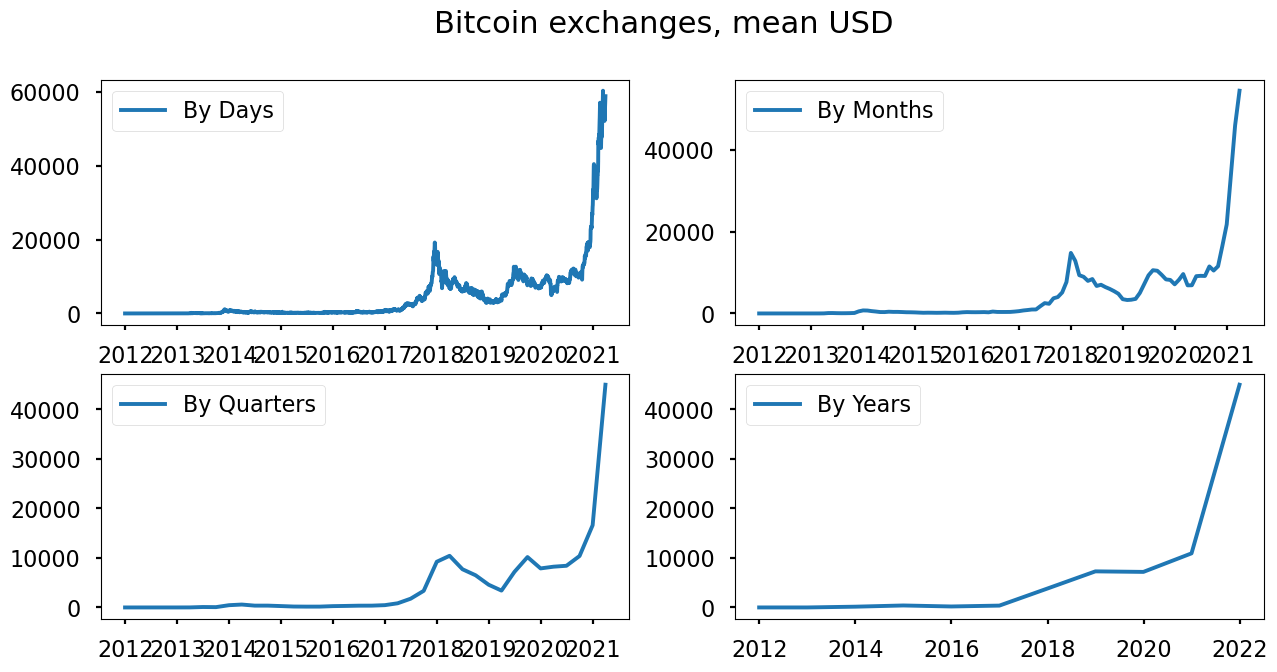

In [67]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

## Stationarity check and STL-decomposition of the series 

Dickey–Fuller test: p=0.998850


<Figure size 1500x700 with 0 Axes>

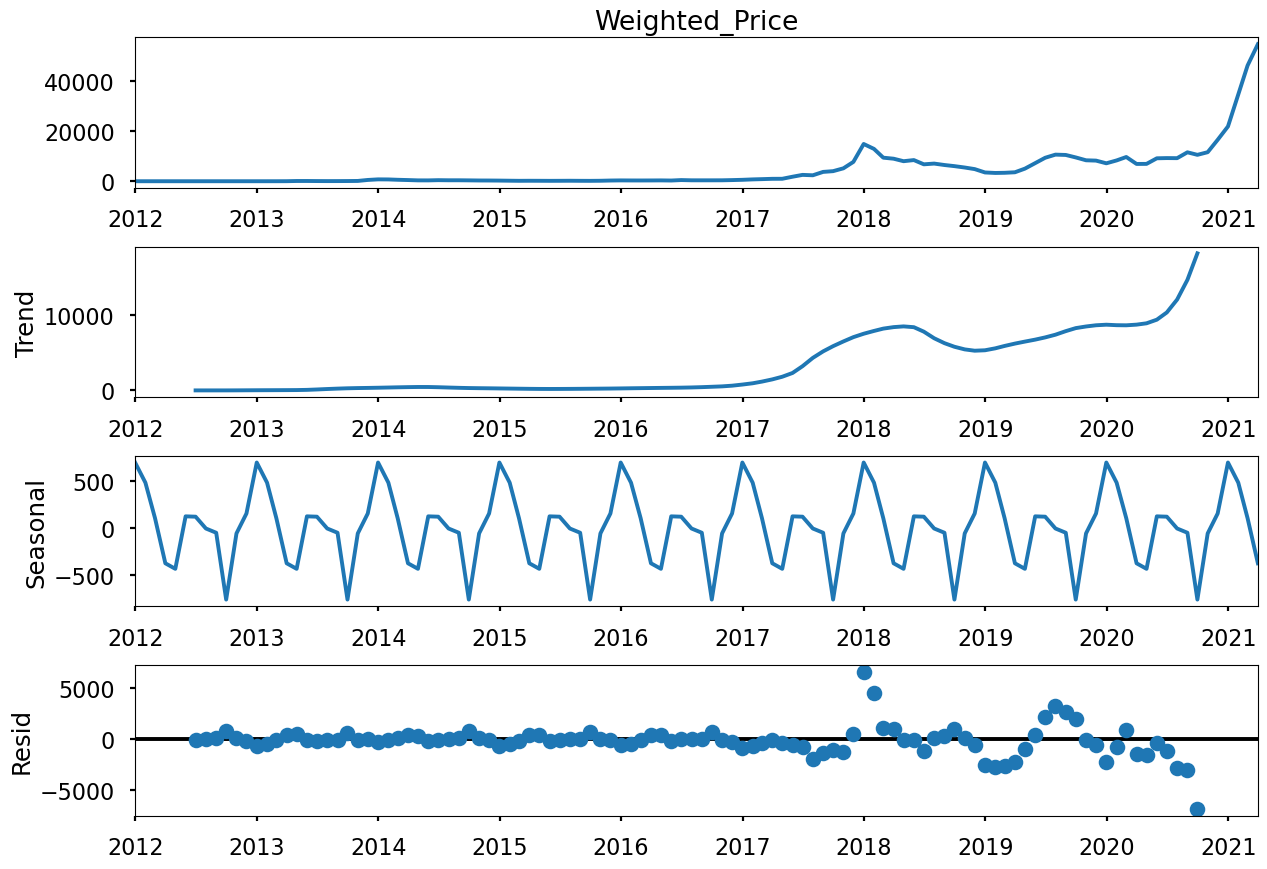

In [68]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()

# Dickey-Fuller 검정 
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

- p value가 0.9 정도 나왔으므로, 이 데이터는 stationary 하지 않다. 

## Box-Cox Transformations

In [69]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998850


## Seasonal differentiation

In [70]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.346684


## Regular differentiation 

Dickey–Fuller test: p=0.000068


<Figure size 1500x700 with 0 Axes>

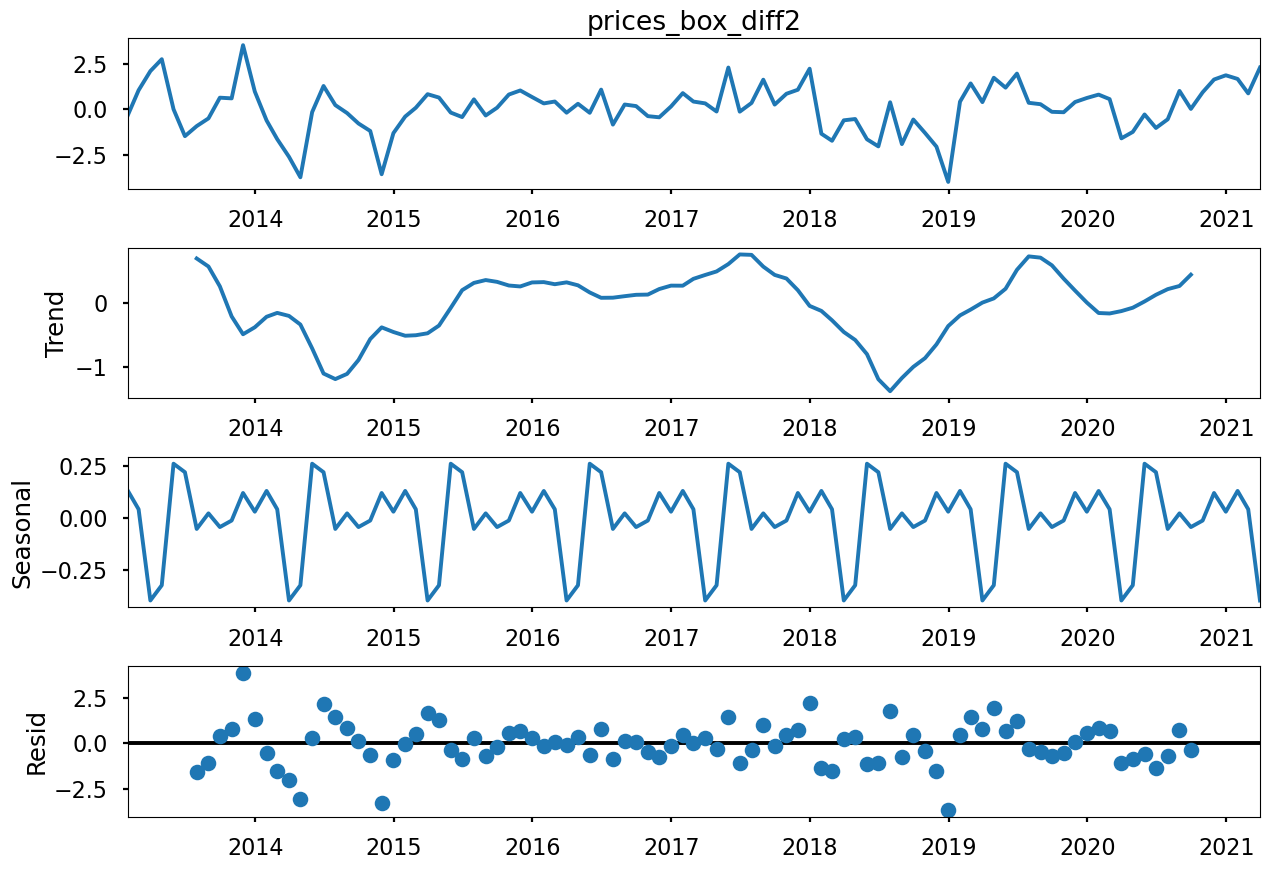

In [71]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

## Model Selection 

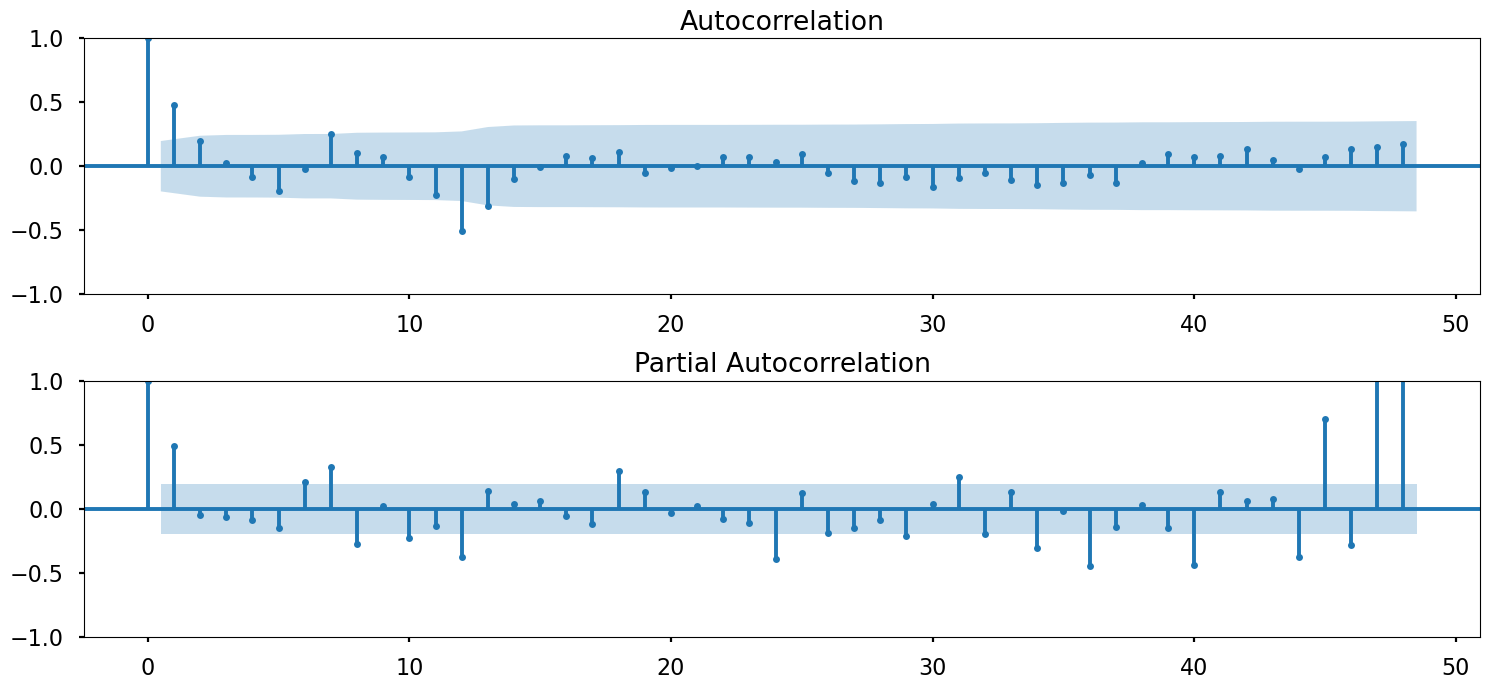

In [72]:
# Autocorrelation, Partial Autocorrelation 통해 ARIMA 모델 추기 파라미터 추정 
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [73]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [74]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  261.370051
43  (2, 1, 0, 1)  262.624720
21  (1, 0, 1, 1)  262.764482
7   (0, 1, 0, 1)  263.185870
25  (1, 1, 0, 1)  263.261172
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -127.685
Date:                              Sun, 14 Jan 2024   AIC                            261.370
Time:                                      10:06:51   BIC                            269.155
Sample:                                  12-31-2011   HQIC                           264.520
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


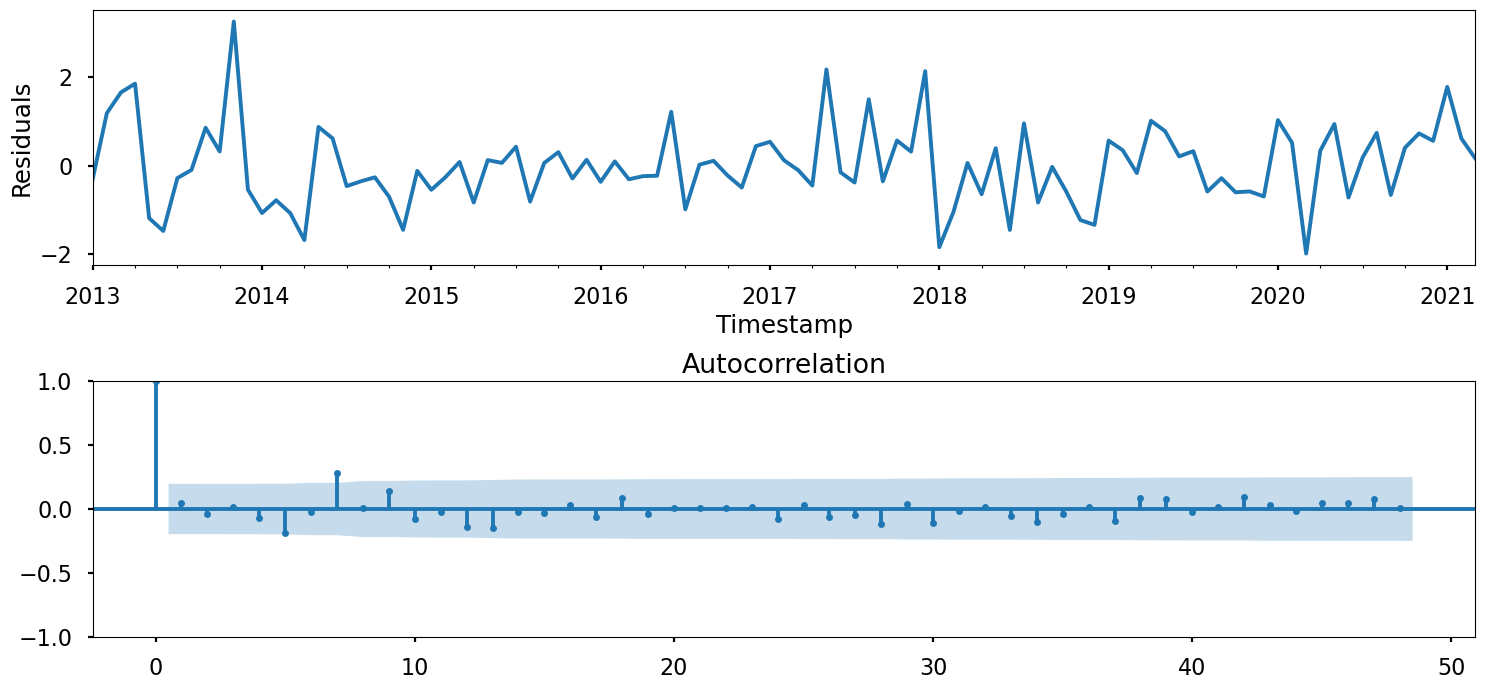

In [75]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Prediction 

In [76]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

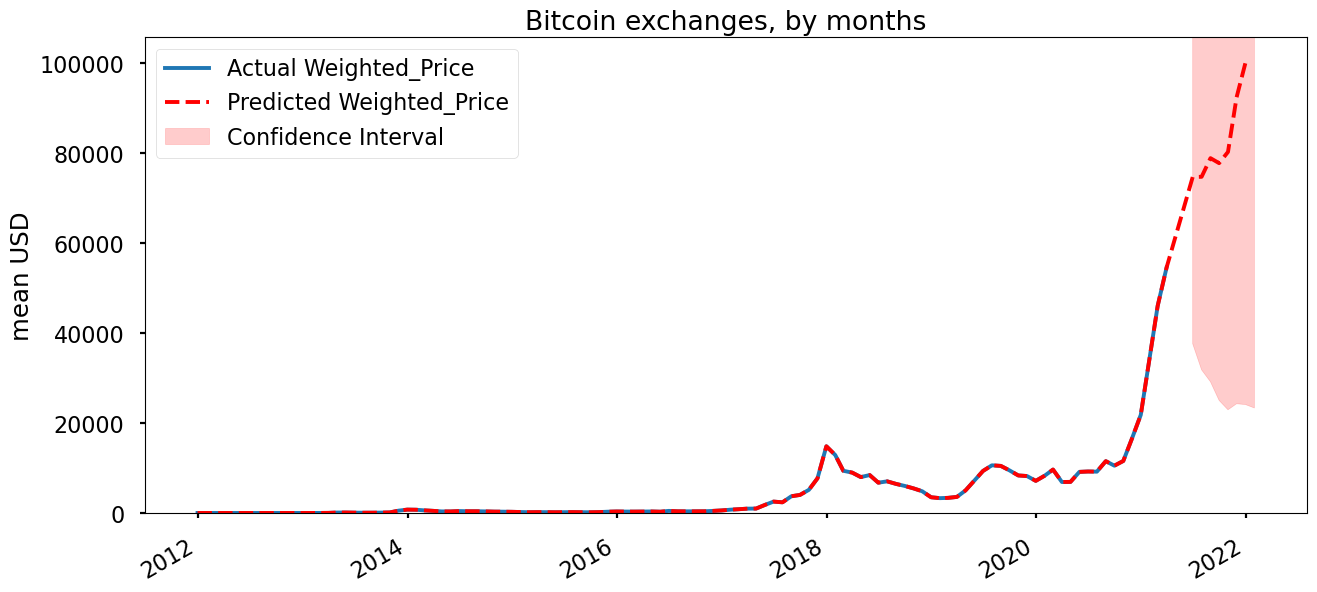

In [77]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2021, 6, 30), datetime(2021, 7, 31), datetime(2021, 8, 31), datetime(2021, 9, 30), 
             datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31), datetime(2022, 1, 31),
             datetime(2022, 1, 28)]
future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = pd.concat([df_month2, future])

prediction = best_model.get_prediction(start=date_list[0], end=date_list[-1])

prediction_values = invboxcox(prediction.predicted_mean, lmbda)
prediction_conf_int = invboxcox(prediction.conf_int(), lmbda)

df_month2['forecast'] = np.nan
df_month2.loc[prediction_values.index, 'forecast'] = prediction_values

df_month2['forecast'].update(df_month2['Weighted_Price'])


plt.figure(figsize=(15, 7))
df_month2.Weighted_Price.plot(label='Actual Weighted_Price')
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.fill_between(prediction_conf_int.index, prediction_conf_int.iloc[:, 0], prediction_conf_int.iloc[:, 1], color='red', alpha=0.2, label='Confidence Interval')

plt.ylim(bottom=min(df_month2['Weighted_Price'].min(), df_month2['forecast'].min()) - 100,
         top=max(df_month2['Weighted_Price'].max(), df_month2['forecast'].max()) + 100)

plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()